# Import necessary packages

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


# Import labeled dataset

In [2]:
Paris_1 = pd.read_csv('Coding_Paris_Week1.csv')
Paris_2 = pd.read_csv('Coding_Paris_Week2.csv')
Paris_3 = pd.read_csv('Coding_Paris_Week3.csv')
Paris_4 = pd.read_csv('Coding_Paris_Week4.csv')
Paris_5 = pd.read_csv('Coding_Paris_Week5.csv')
Shawn_1 = pd.read_csv('Coding_Shawn_Week1.csv')
Shawn_2 = pd.read_csv('Coding_Shawn_Week2.csv')
Shawn_3 = pd.read_csv('Coding_Shawn_Week3.csv')
Shawn_4 = pd.read_csv('Coding_Shawn_Week4.csv')
Shawn_5 = pd.read_csv('Coding_Shawn_Week5.csv')
Tianli_1 = pd.read_csv('Coding_Tianli_Week1.csv')
Tianli_2 = pd.read_csv('Coding_Tianli_Week2.csv')
Tianli_3 = pd.read_csv('Coding_Tianli_Week3.csv')
Tianli_4 = pd.read_csv('Coding_Tianli_Week4.csv')
Tianli_5 = pd.read_csv('Coding_Tianli_Week5.csv')

# Merge the labeled data

In [3]:
# Combine all the data frames into one
combined_df = pd.concat([
    Paris_1, Paris_2, Paris_3, Paris_4, Paris_5,
    Shawn_1, Shawn_2, Shawn_3, Shawn_4, Shawn_5,
    Tianli_1, Tianli_2, Tianli_3, Tianli_4, Tianli_5
], ignore_index=True)

combined_df['Sentiment'] = combined_df['Sentiment'].astype(int)



# Check the combined data frame
combined_df

,Tweet,Sentiment
0,RT @biancale_monash ATTN: Aus women interested...,3
1,The future will be full of lab grown meat: htt...,1
2,The Future Of Meat: 45 In Vitro Meat Recipes Y...,4
3,Some makers of lab-grown meat have adopted a c...,3
4,Lab grown meat doesn’t sit well with me,2
...,...,...
22970,I've unexpectedly ended up with David Lewis on...,3
22971,cheap cultivated meat https://t.co/hsXLscDaVS,3
22972,"@BobsBlog I mean to be clear, it depends exact...",3
22973,The market for cultured meat is no joke (prese...,3


# Preprocessing:
For VADER and BERT, we performed tokenization and removed usernames, URLs, hashtag symbols (“#”), and tweet-specific terms (i.e., “RT” and “&amp”). Additionally, all words were converted to lowercase

In [11]:
import gensim
import gensim.corpora as corpora
import re
b = []
for i,u in combined_df.iterrows():
    a = []
    word =''
    for words in str(u['Tweet']).split():
        if '@' not in words: #remove usernames
            words = words.replace('#','') #remove hashtag symbols
            if '#' not in words:
                if "http" not in words: # remove URLs
                    if '&amp' not in words: #remove tweet-specific terms
                        if 'RT' not in words:
                            word += (words +' ')
    doc = ''
    for token in word.split():
        token = token.lower() #lowercase
        doc += (token+' ')
    b.append(doc)
combined_df['processed'] = [i for i in b]

# The hyper parameters for BERT (following the recommendation of its authors):
- Learning rate: 2e-5
- Batch size: 16
- Number of epoches: 3
- Optimizer: AdamW
- Linear scheduler

In [14]:
# 1. Load the data
df = combined_df
tweets = df['processed'].tolist()
labels = [label-1 for label in df['Sentiment'].tolist()]  # Adjusting labels from 1-4 to 0-3 because the outputs of BERT start from 0

# 2. Define a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 3. Split the data into training and validation sets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

dataset = SentimentDataset(tweets=tweets, labels=labels, tokenizer=tokenizer, max_len=MAX_LEN)
train_size = int(0.8 * len(dataset)) #80% labeled data as training data
val_size = len(dataset) - train_size #20% labeled data as testing data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) #randomly split the labeled dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 5. Define optimizer, scheduler, and loss
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# 6. Train the model
for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

# 7. Save the model
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

('./sentiment_model\\tokenizer_config.json',
 './sentiment_model\\special_tokens_map.json',
 './sentiment_model\\vocab.txt',
 './sentiment_model\\added_tokens.json')

# Evaluate the performance of the fine-tuned BERT using accuracy and weighted F1

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Function to evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()  # set model to evaluation mode

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    
    return accuracy, precision, recall, f1

# After training the model, evaluate its performance
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

C:\Users\11527\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy: 0.7976060935799782
Precision: 0.8006212136535319
Recall: 0.7976060935799782
F1 Score: 0.7986431373443679


In [2]:
import pandas as pd
validation_df = pd.read_csv('bert_validation_predictions_with_tweets.csv')

In [3]:
validation_df

,Tweet,True Label,Predicted Label
0,@csimpsyo @Tbogin @jonlovett Cultured meat,2,2
1,RT @ndonyourtable What's the difference betwee...,2,2
2,#Technology #Tech Lab-Grown Meat Is Coming htt...,2,2
3,This year is the first time cultivated meat ha...,2,2
4,"RT @NewHarvestOrg 🍗and @UmaValeti, who co-foun...",2,2
...,...,...,...
4590,@Joseph_Plant What goes into lab grown meat? I...,1,1
4591,Google Funding Lab Grown Meat… No Animals Kill...,0,0
4592,RT @Orbyne #LSEForum cultured meat avoids the ...,0,0
4593,@MusadADroid @AuthorGusPegel The answer would ...,3,0


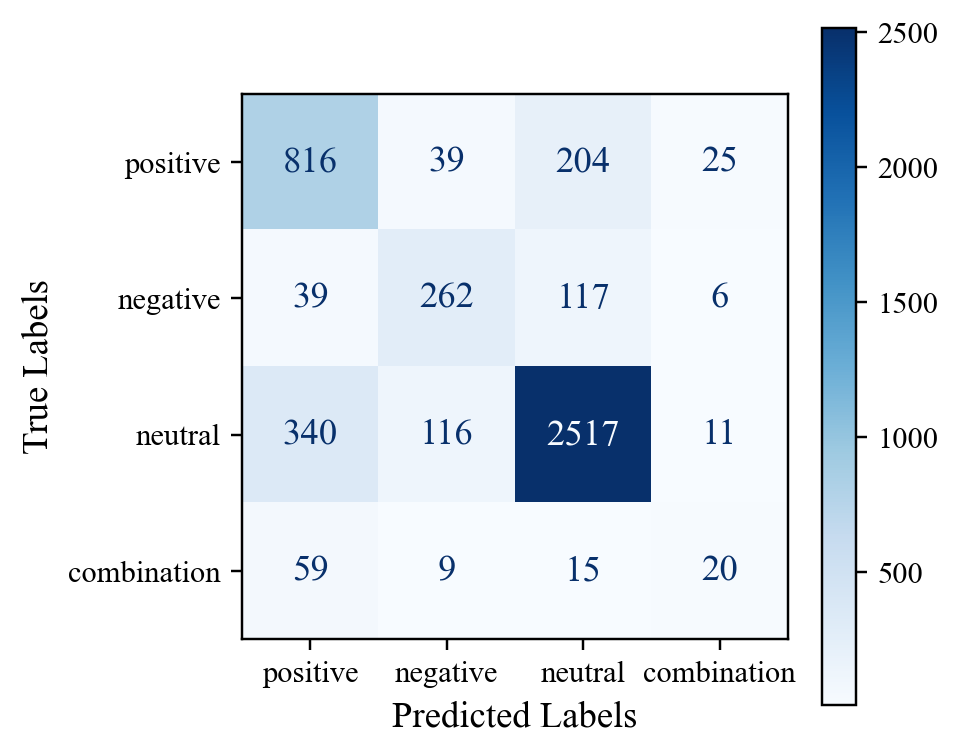

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define a mapping of numeric labels to sentiment labels
label_mapping = {0: 'positive', 1: 'negative', 2: 'neutral', 3: 'combination'}
sentiment_labels = [label_mapping[i] for i in range(4)]  # List of sentiment labels in order

# Generate the confusion matrix
conf_matrix = confusion_matrix(validation_df['True Label'], validation_df['Predicted Label'])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sentiment_labels)

# Plot the confusion matrix
plt.rc('font', family='Times New Roman')  # Set the font to Times New Roman
fig, ax = plt.subplots(figsize=(4, 4), dpi=220)  # Increase figure size and resolution
disp.plot(cmap='Blues', ax=ax, values_format='d')  # Format numbers as integers

# Customize the text size of numbers in the matrix
for text in disp.text_.ravel():
    text.set_fontsize(12)  # Increase font size of numbers in the matrix

# Set titles and labels with the desired font
#plt.title("Confusion Matrix", fontname='Times New Roman', fontsize=14)
plt.xlabel("Predicted Labels", fontname='Times New Roman', fontsize=12)
plt.ylabel("True Labels", fontname='Times New Roman', fontsize=12)
plt.show()